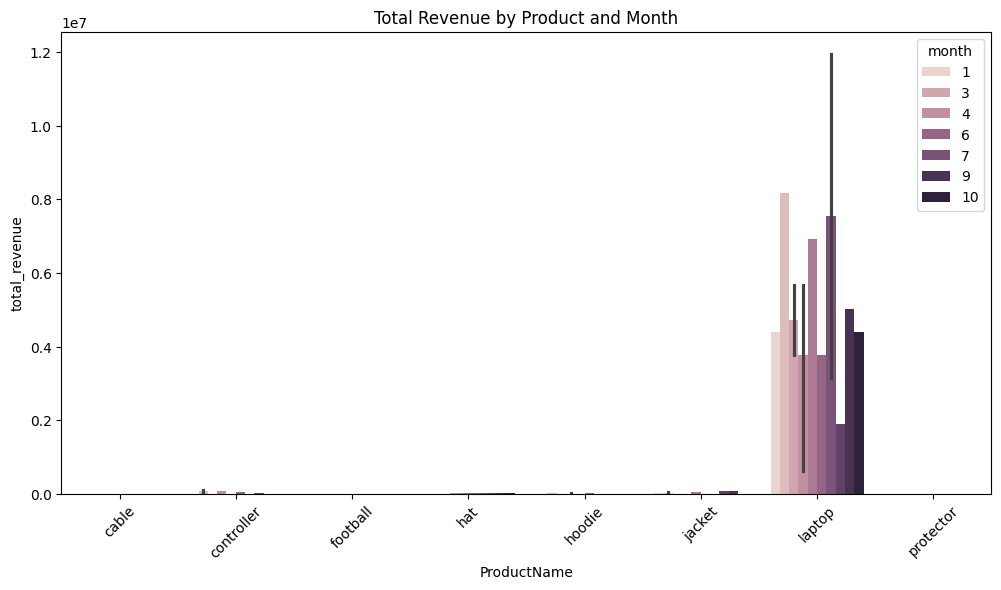

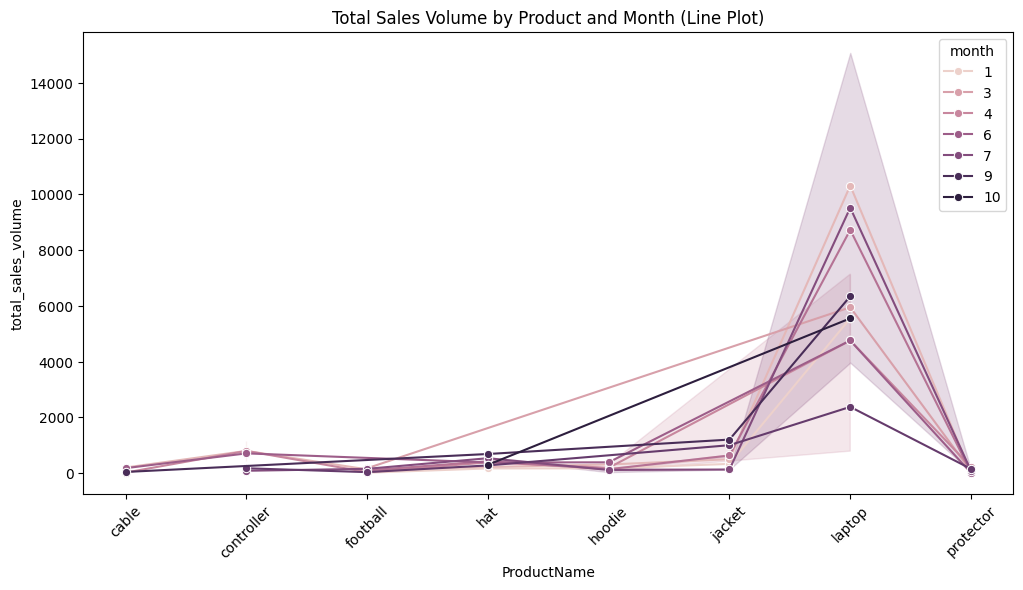

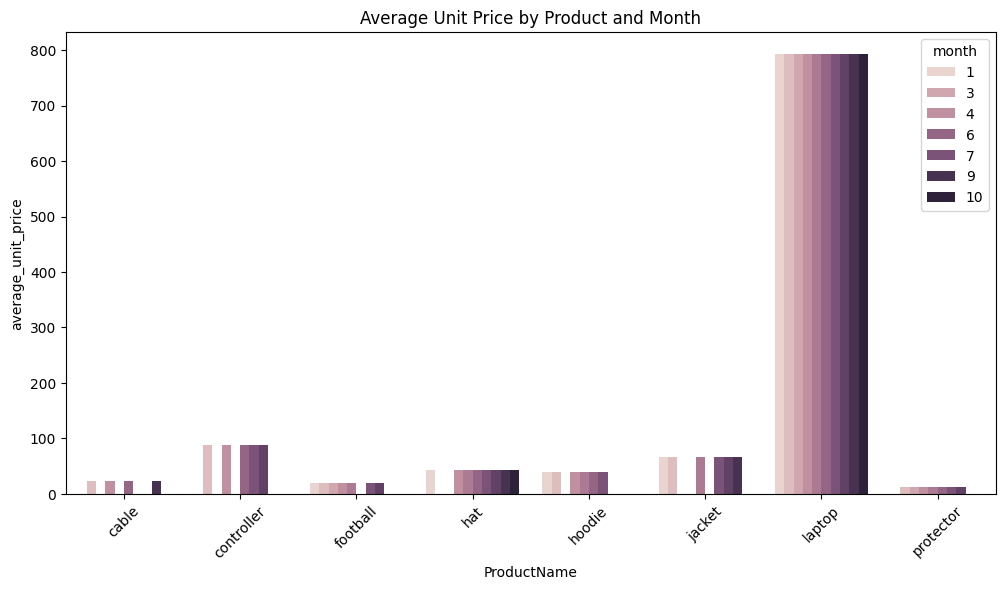

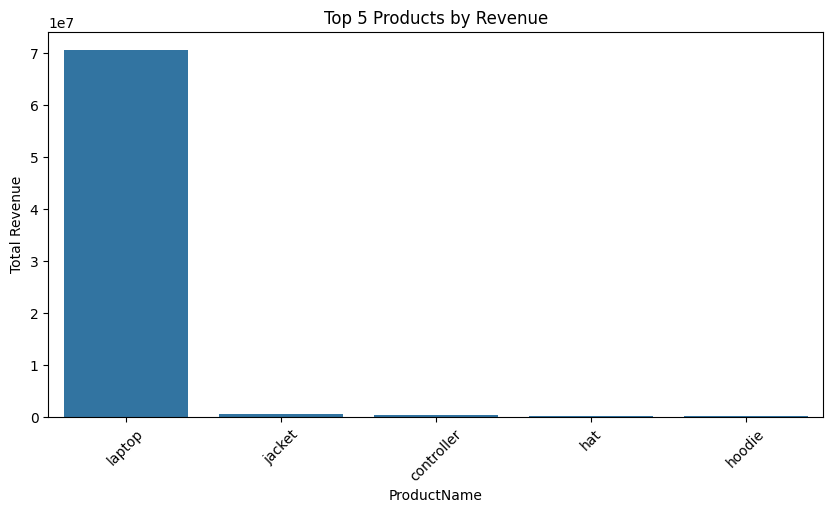

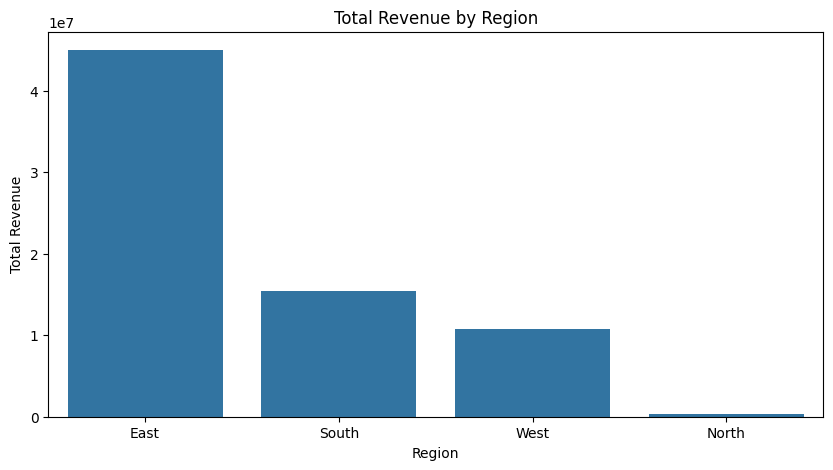

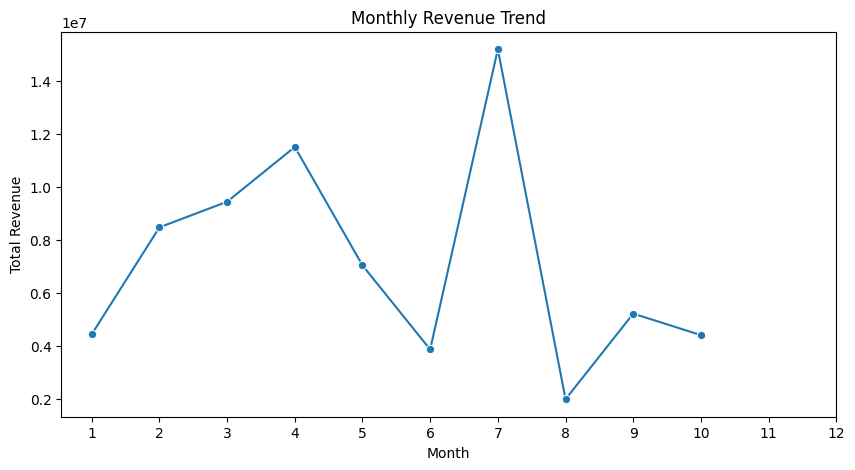

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# File paths
sales_csv = "/Users/stephneyaganaga/Desktop/school-assessment/smart-sales-blessing/data/prepared/sales_data_prepared.csv"
products_csv = "/Users/stephneyaganaga/Desktop/school-assessment/smart-sales-blessing/data/prepared/products_data_prepared.csv"
customers_csv = "/Users/stephneyaganaga/Desktop/school-assessment/smart-sales-blessing/data/prepared/customers_data_prepared.csv"

# Create directory for visuals if it doesn't exist
os.makedirs("visuals", exist_ok=True)

# Load data
df_sales = pd.read_csv(sales_csv)
df_products = pd.read_csv(products_csv)
df_customer = pd.read_csv(customers_csv)

# Join and transform data
df_full = df_sales.merge(df_products, on="ProductID").merge(df_customer, on="CustomerID")
df_full["sale_date_parsed"] = pd.to_datetime(df_full["SaleDate"])
df_full["month"] = df_full["sale_date_parsed"].dt.month
df_full["year"] = df_full["sale_date_parsed"].dt.year
df_full["revenue"] = df_full["SaleAmount"] * df_full["UnitPrice"]
df_full["profitability"] = df_full["revenue"] * 0.2

# Aggregation
df_aggregated = df_full.groupby(["ProductName", "month", "Region"]).agg(
    total_sales_volume=("SaleAmount", "sum"),
    average_unit_price=("UnitPrice", "mean"),
    total_revenue=("revenue", "sum")
).reset_index()

# Visualization - Total Revenue by Product and Month
plt.figure(figsize=(12, 6))
sns.barplot(data=df_aggregated, x="ProductName", y="total_revenue", hue="month")
plt.xticks(rotation=45)
plt.title("Total Revenue by Product and Month")
plt.savefig("visuals/revenue_by_product_month.png", bbox_inches='tight')
plt.show()

# Visualization - Total Sales Volume by Product and Month (Line Plot)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_aggregated, x="ProductName", y="total_sales_volume", hue="month", marker="o")
plt.xticks(rotation=45)
plt.title("Total Sales Volume by Product and Month (Line Plot)")
plt.savefig("visuals/sales_volume_by_product_month.png", bbox_inches='tight')
plt.show()

# Visualization - Average Unit Price by Product and Month
plt.figure(figsize=(12, 6))
sns.barplot(data=df_aggregated, x="ProductName", y="average_unit_price", hue="month")
plt.xticks(rotation=45)
plt.title("Average Unit Price by Product and Month")
plt.savefig("visuals/avg_price_by_product_month.png", bbox_inches='tight')
plt.show()

# Additional insights - Top products by revenue
top_products = df_full.groupby("ProductName")["revenue"].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_products.index, y=top_products.values)
plt.xticks(rotation=45)
plt.title("Top 5 Products by Revenue")
plt.ylabel("Total Revenue")
plt.savefig("visuals/top_products_by_revenue.png", bbox_inches='tight')
plt.show()

# Regional sales analysis
region_sales = df_full.groupby("Region")["revenue"].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=region_sales.index, y=region_sales.values)
plt.title("Total Revenue by Region")
plt.ylabel("Total Revenue")
plt.savefig("visuals/revenue_by_region.png", bbox_inches='tight')
plt.show()

# Monthly revenue trend
monthly_revenue = df_full.groupby("month")["revenue"].sum()
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue.values, marker='o')
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(range(1, 13))
plt.savefig("visuals/monthly_revenue_trend.png", bbox_inches='tight')
plt.show()

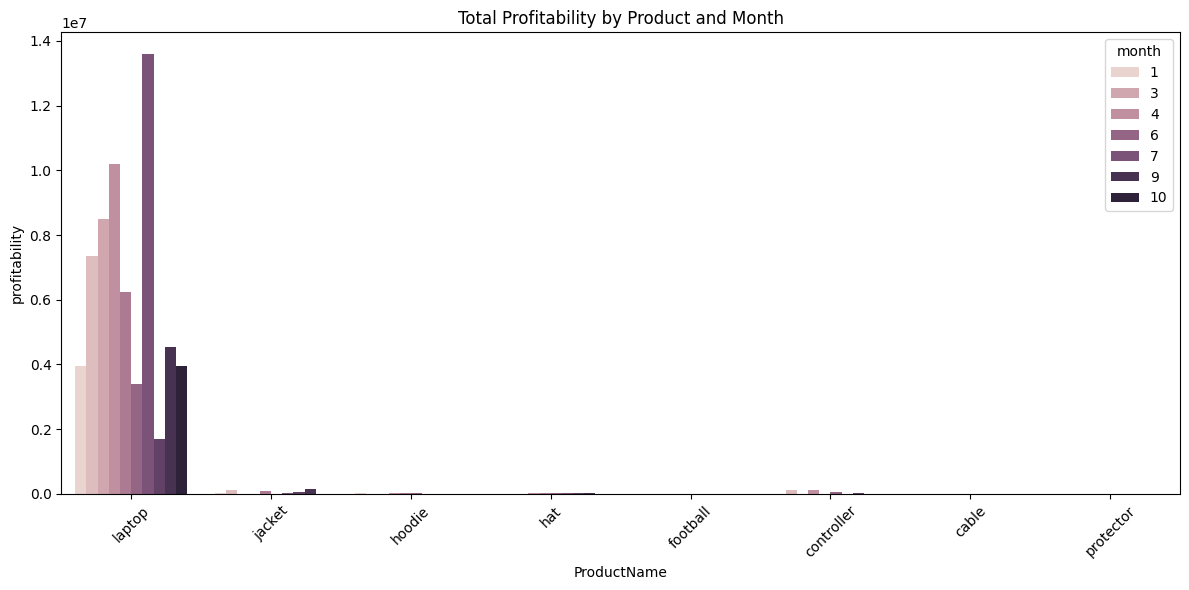

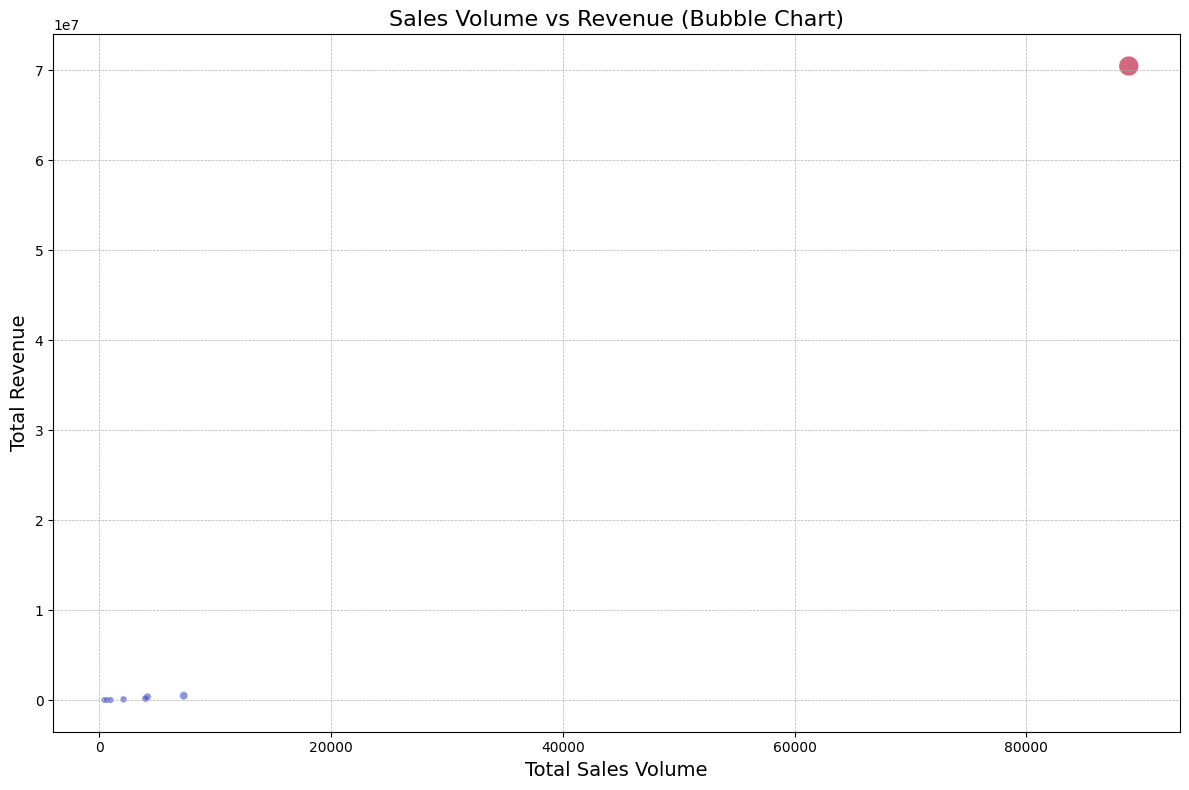

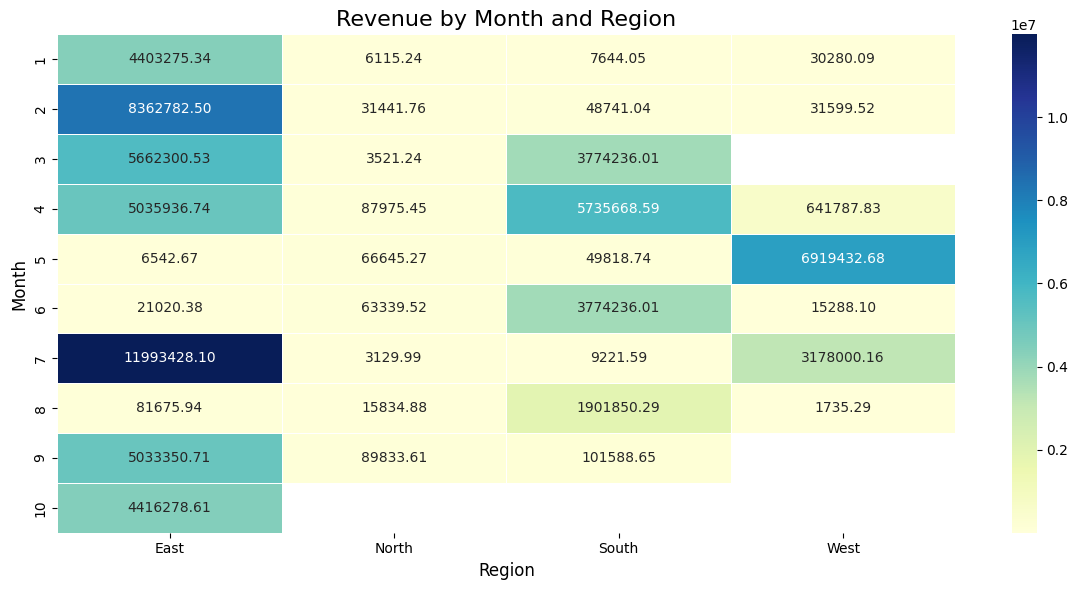

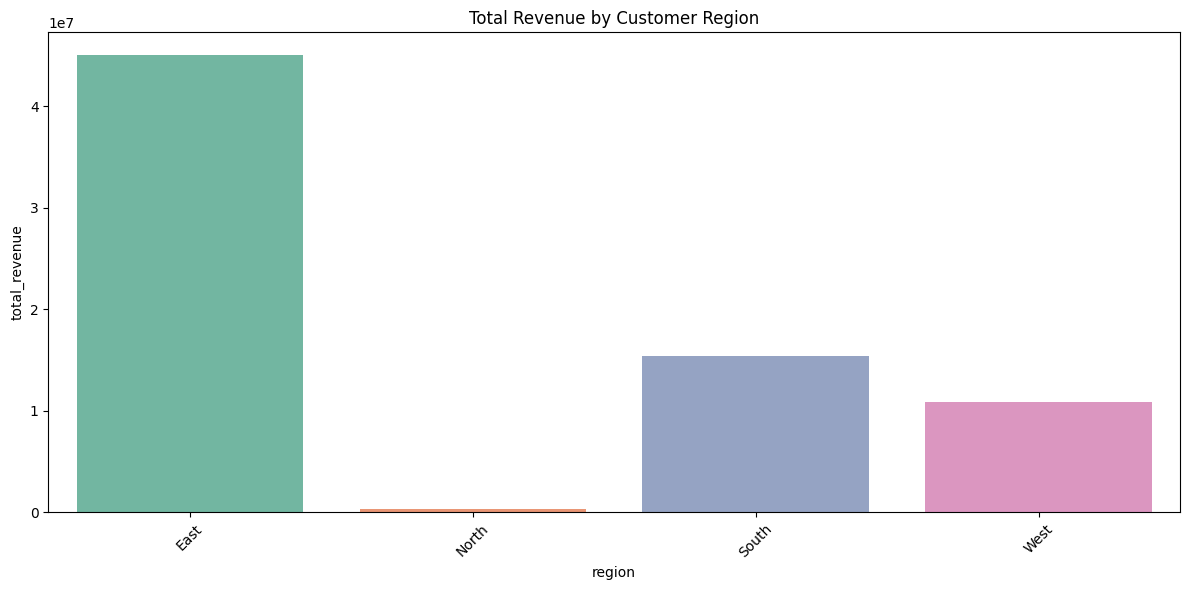

<Figure size 1400x800 with 0 Axes>

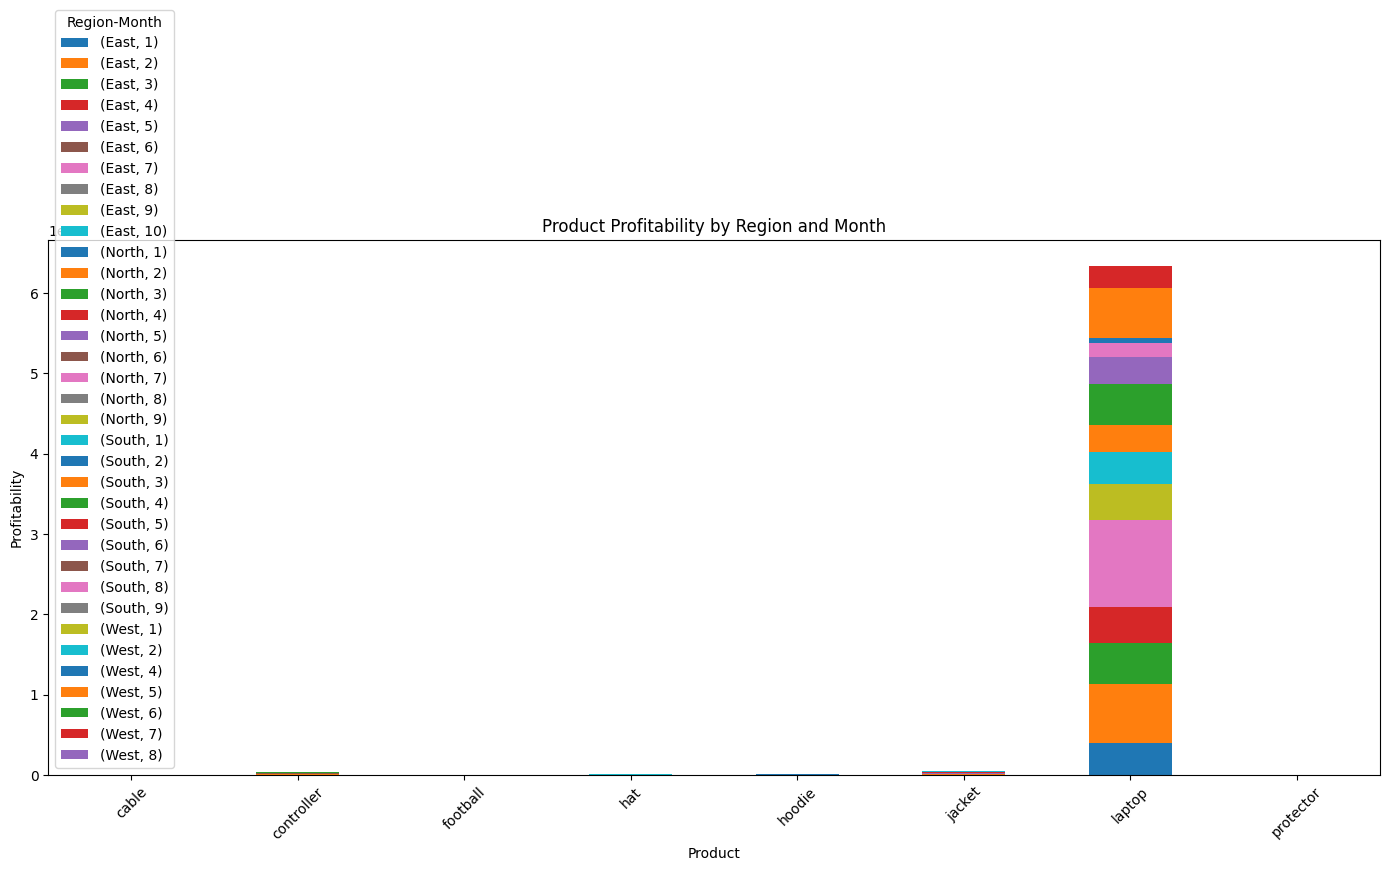

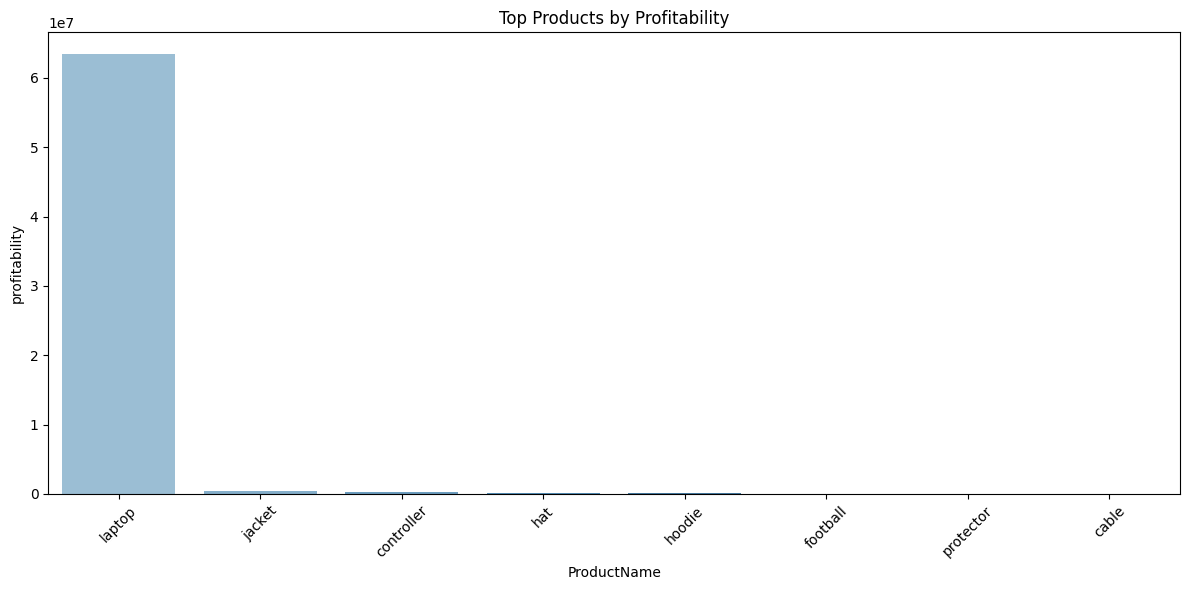

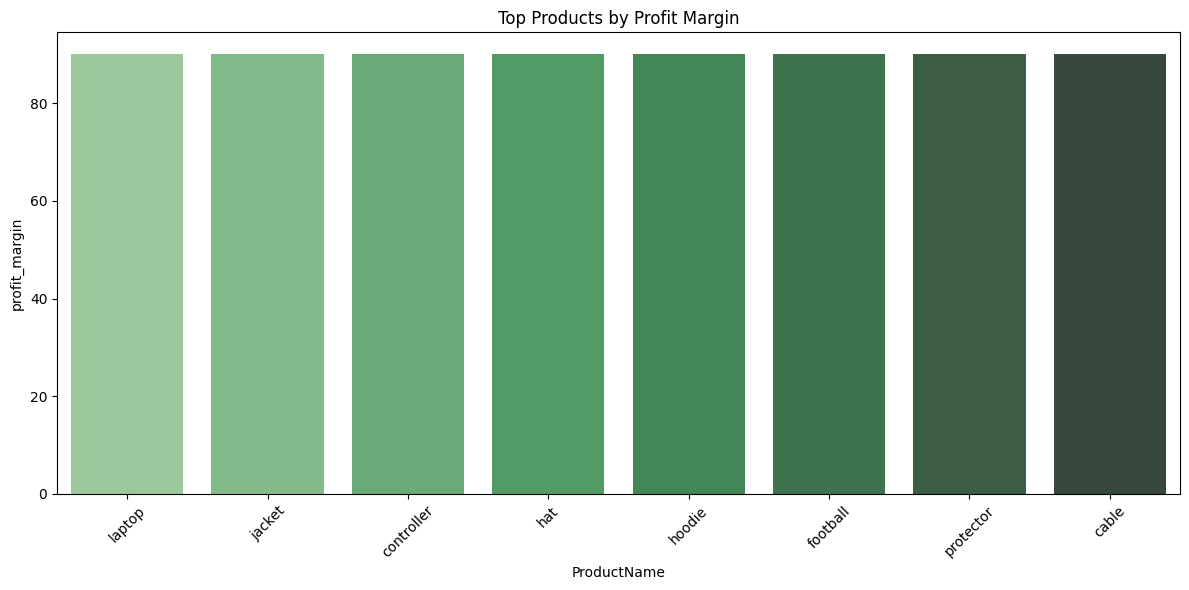

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load your data
sales_path = "/Users/stephneyaganaga/Desktop/school-assessment/smart-sales-blessing/data/prepared/sales_data_prepared.csv"
products_path = "/Users/stephneyaganaga/Desktop/school-assessment/smart-sales-blessing/data/prepared/products_data_prepared.csv"
customers_path = "/Users/stephneyaganaga/Desktop/school-assessment/smart-sales-blessing/data/prepared/customers_data_prepared.csv"

df_sales = pd.read_csv(sales_path)
df_products = pd.read_csv(products_path)
df_customers = pd.read_csv(customers_path)

# Merge sales and products data to get UnitPrice and ProductName
df_full = pd.merge(df_sales, df_products[['ProductID', 'ProductName', 'UnitPrice']], on='ProductID', how='left')

# 👉 Merge customer data to bring in 'region'
df_full = pd.merge(df_full, df_customers[['CustomerID', 'Region']], on='CustomerID', how='left')
df_full.rename(columns={'Region': 'region'}, inplace=True)

# Extract 'month' from SaleDate
df_full['month'] = pd.to_datetime(df_full['SaleDate']).dt.month

# Create 'revenue' column
df_full['revenue'] = df_full['SaleAmount'] * df_full['UnitPrice']

# Create 'profitability' column (simple mock: 10% cost assumed)
df_full['profitability'] = df_full['revenue'] - (df_full['UnitPrice'] * df_full['SaleAmount'] * 0.1)

# Create 'profit_margin' column as a percentage of profitability over revenue
df_full['profit_margin'] = (df_full['profitability'] / df_full['revenue']) * 100

# Create output folder if it doesn't exist
os.makedirs("visuals", exist_ok=True)

# 1. Profitability by Product and Month
df_profitability_agg = df_full.groupby(['ProductName', 'month'])['profitability'].sum().reset_index()
df_profitability_agg = df_profitability_agg.sort_values(['month', 'profitability'], ascending=[True, False])

plt.figure(figsize=(12, 6))
sns.barplot(data=df_profitability_agg, x="ProductName", y="profitability", hue="month")
plt.xticks(rotation=45)
plt.title("Total Profitability by Product and Month")
plt.tight_layout()
plt.savefig("visuals/profitability_by_product_and_month.png")
plt.show()

# 2. Bubble Chart: Sales Volume vs Revenue
df_bubble = df_full.groupby("ProductName").agg({
    "SaleAmount": "sum",
    "revenue": "sum"
}).reset_index()
df_bubble.columns = ["ProductName", "total_sales_volume", "total_revenue"]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_bubble,
    x="total_sales_volume", y="total_revenue",
    size="total_sales_volume", hue="total_revenue",
    palette="coolwarm", sizes=(20, 200), alpha=0.6, legend=None
)
plt.title("Sales Volume vs Revenue (Bubble Chart)", fontsize=16)
plt.xlabel("Total Sales Volume", fontsize=14)
plt.ylabel("Total Revenue", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("visuals/bubble_sales_volume_vs_revenue.png")
plt.show()

# 3. Heatmap of Revenue by Month and Region
df_revenue_region_month = df_full.groupby(["month", "region"])["revenue"].sum().reset_index()

# Pivot the data for heatmap
heatmap_data = df_revenue_region_month.pivot(index="month", columns="region", values="revenue")

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)

# Add titles and labels
plt.title("Revenue by Month and Region", fontsize=16)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Month", fontsize=12)

# Show the plot
plt.tight_layout()
plt.savefig("visuals/heatmap_revenue_by_month_region.png")
plt.show()

# 4. Customer Segmentation: Revenue and Sales Volume by Region
df_customer_segmentation = df_full.groupby("region").agg({
    "revenue": "sum",
    "SaleAmount": "sum"
}).reset_index()
df_customer_segmentation.columns = ["region", "total_revenue", "total_sales_volume"]

plt.figure(figsize=(12, 6))
sns.barplot(data=df_customer_segmentation, x="region", y="total_revenue", hue="region", palette="Set2", legend=False)
plt.xticks(rotation=45)
plt.title("Total Revenue by Customer Region")
plt.tight_layout()
plt.savefig("visuals/revenue_by_region.png")
plt.show()

# 5. Aggregating product profitability by region and month
df_profit_region_month = df_full.groupby(['ProductName', 'region', 'month'])['profitability'].sum().reset_index()

# Creating a pivot table for visualization
profit_pivot = df_profit_region_month.pivot_table(index='ProductName', columns=['region', 'month'], values='profitability', aggfunc='sum')

# Plotting: Stacked bar chart of profitability by region for each product
plt.figure(figsize=(14, 8))
profit_pivot.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Product Profitability by Region and Month')
plt.xlabel('Product')
plt.ylabel('Profitability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Region-Month")
plt.savefig("visuals/product_profit_by_region_month.png")
plt.show()

# 6. Aggregating top products by profitability
df_top_products = df_full.groupby("ProductName").agg({
    "profit_margin": "mean",  # Average profit margin per product
    "profitability": "sum"  # Total profitability
}).reset_index()

# Sorting by profitability
df_top_products = df_top_products.sort_values('profitability', ascending=False)

# Visualization: Top Products by Profitability and Profit Margin
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_products, x='ProductName', y='profitability', hue='ProductName', palette="Blues_d", legend=False)
plt.xticks(rotation=45)
plt.title("Top Products by Profitability")
plt.tight_layout()
plt.show()

# Optionally, add a second chart for Profit Margin
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_products, x='ProductName', y='profit_margin', hue='ProductName', palette="Greens_d", legend=False)
plt.xticks(rotation=45)
plt.title("Top Products by Profit Margin")
plt.tight_layout()
plt.show()
